# MASH results on V8 data
Mostly using various plots we had for the mash paper.

Here I explore results from a later run on V8 data using the refactored `mashr`, and compare results with analysis in mash paper on V6 data.

In [1]:
library(lattice)
library(ggplot2)
library(colorRamps)
library(mashr)
library(repr)

Loading required package: ashr


In [2]:
res = readRDS('~/Documents/GTExV8/MASH/GTExV8.ciseQTL.4MASH.cov.K5.P5.mash_model.rds')
res$result = readRDS('~/Documents/GTExV8/MASH/GTExV8.ciseQTL.4MASH.cov.K5.P5.mash_posterior.rds')

## MASH model fit
The log-likelihood of fit is:

In [9]:
get_loglik(res)

[1] -10010029

Here is a plot of weights learned.

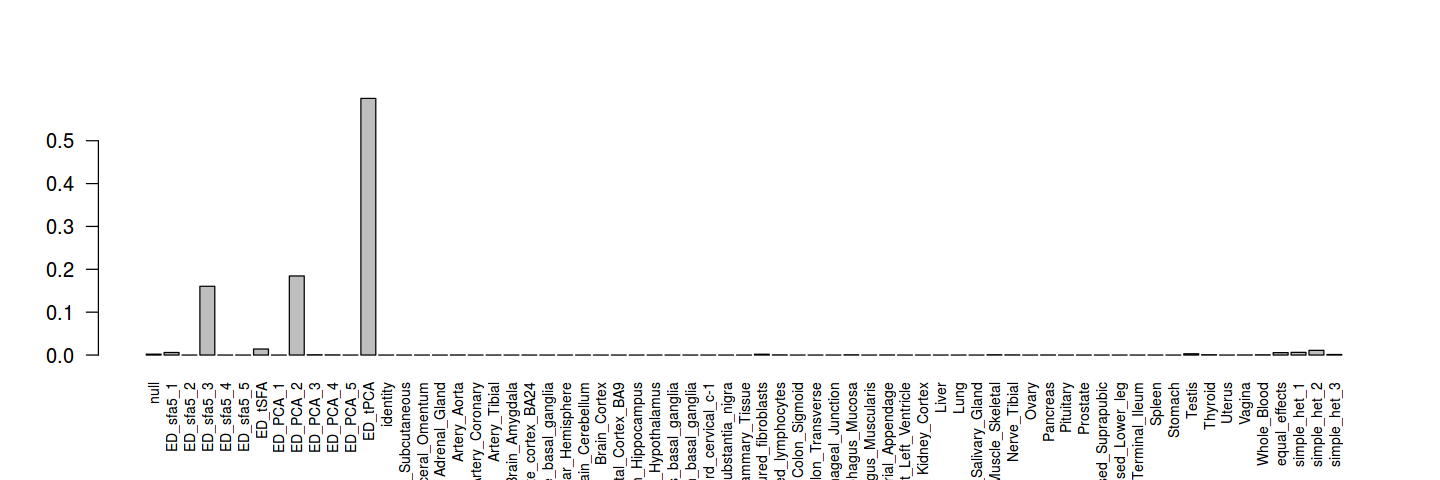

In [3]:
options(repr.plot.width=12, repr.plot.height=4)
barplot(get_estimated_pi(res), las = 2, cex.names = 0.7)

The rank 5 PCA component accounts for 58% of all weights in the GTEx data. Here is a visualization for it (via correlation heatmap):

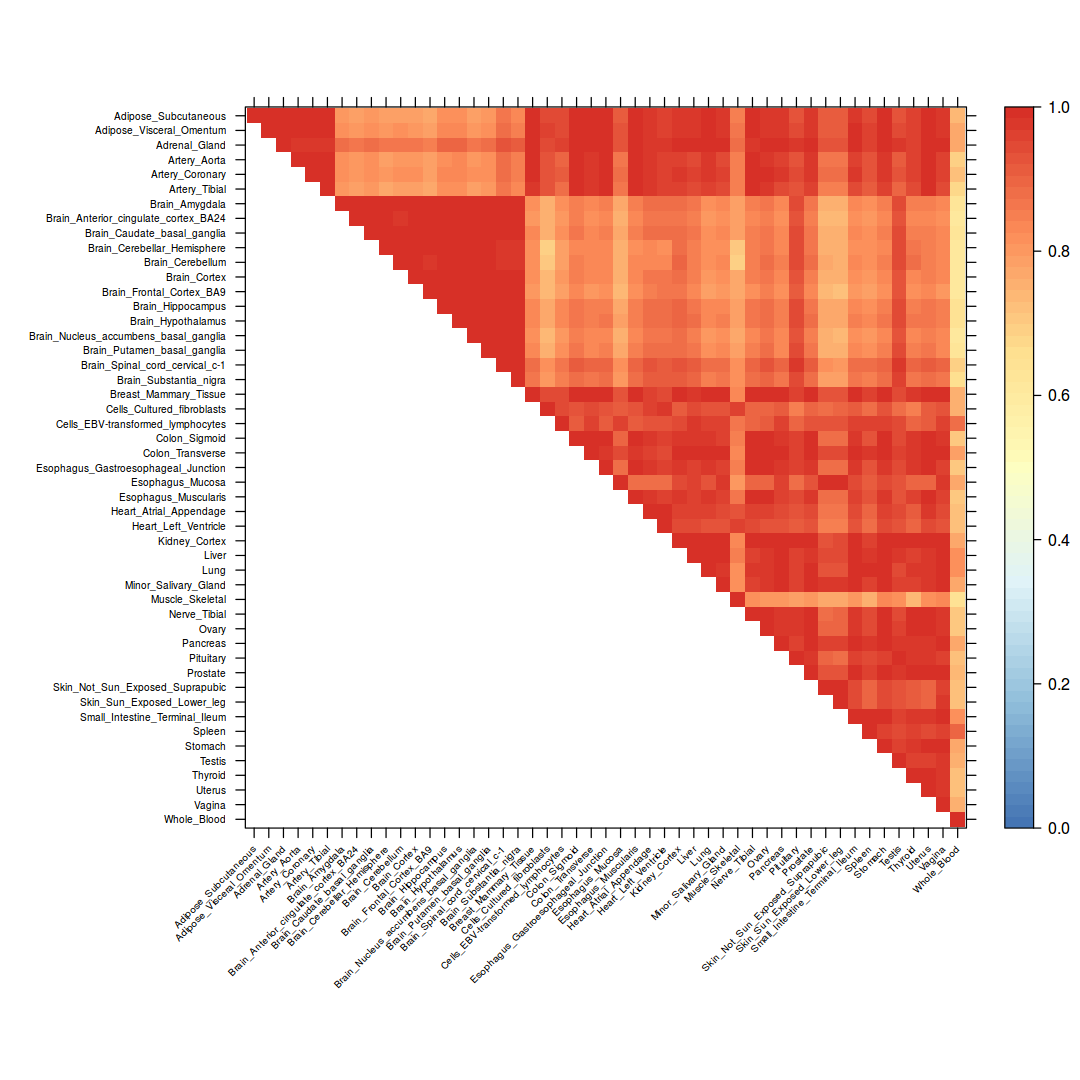

In [4]:
x           <- cov2cor(res$fitted_g$Ulist[["ED_tPCA"]])
x[x < 0]    <- 0
colnames(x) <- colnames(get_lfsr(res))
rownames(x) <- colnames(x)
x <- x[rev(rownames(x)),rev(colnames(x))]
x[lower.tri(x)] <- NA
clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
                               "#E0F3F8","#91BFDB","#4575B4")))(64)
n <- nrow(x)
options(repr.plot.width=9, repr.plot.height=9)
print(levelplot(x[n:1,],col.regions = clrs,xlab = "",ylab = "",
                colorkey = TRUE, at = seq(0,1,length.out = 64),
                scales = list(cex = 0.5,x = list(rot = 45))))

We can see that brain tissues are correlated, so are non-brain tissues. But correlations between brain / non-brain tissues are smaller. Also, muscle skeletal tissues and whole blood are less correlated to other tissues.

## Posterior quantities

In [5]:
lfsr = get_lfsr(res)
pm = get_pm(res)

## eQTLs discovered
Use lfsr cutoff `0.01`.

In [ ]:
sig_results = list()
for (i in colnames(lfsr)) {
    sig_results[[i]] = names(get_significant_results(res, conditions = i, thresh = 0.01))
}

## Data-driven patterns of sharing
Defined by "the same sign ahd within a factor of 0.5 of each other".

In [7]:
pairwise_sharing = get_pairwise_sharing(res, factor = 0.5)
pairwise_sharing_sign = get_pairwise_sharing(res, factor = 0)